# 개발환경 : Python 3.6.9, Pytorch 1.6, jupyter 
# Pytorch 설치 방법
https://pytorch.org/get-started/locally/

# 사용된 라이브러리 목록
- 일부 사용되지 않는 라이브러리가 있을 수 있음

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from IPython.display import Image
from IPython import display

import itertools
import matplotlib.pyplot as plt
import time
import os
import shutil
import numpy as np
import pandas as pd
import datetime
import sys
from collections import Counter

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import Subset
from albumentations.pytorch.transforms import ToTensor
import torchvision

from sklearn.model_selection import train_test_split
#데이터 분할을 위한 라이브러리

from sklearn.metrics import f1_score


ModuleNotFoundError: No module named 'albumentations'

# 데이터셋을 학습 데이터와 검증데이터로 분할하는 함수


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.ImageFolder(root= "C:\\Users\\negga\\Desktop\\AiTest\\traindata\\pipe",transform=transform)




In [4]:
def split_dataset(data_path, batch_size, val_split=0.25):
    
    # 폴더에서 이미지를 가져오는 함수
    dataset = datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            transforms.Resize((224,224)), # 이미지는 224*224 로 크기로 조정
            
            ##Resnet18의 input data 의 이미지 크기는 224*224로 주어야하기때문에 Resize
            
            transforms.ToTensor(), # Tensor 타입으로 변경
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # RGB 값을 0~1 사이 값으로 Normalization 함
                     
            #### 왜? mean 과 std의 값을 저것으로 주었는지 위 값들은 Imagenet 에서 사용하는 정규화값들
            
            ## 사진 이미지는 촬영된 주변 환경에 따라 그 명도나 채도 등이 서로 다름
            ## 사진 이미지를 대상으로 하는 머신러닝을 수행하기 전에 이미지들을 동일한 환경으로 맞춰주는 후처리로 전체 이미지에 대한
            ## 화소값의 평균과 표준편차를 구해 이 값을 이미지들에 일괄적으로 적용함
            ## Dataset에 대한 평균과 표준편차를 구하여 mean,std 값으로 줌
            
            ##크게 두가지 연산으로 나눠짐.
            ##scaling : 데이터의 scale을 줄여줌.
            ##centering : 데이터의 중심을 원점으로 맞춰주는 것.
            ##ToTensor()를 해주면 scaling을 해준거고, Normalize를 해주면 centering + rescaling을 해준것.
            ##정확하게 하기 위해선 학습 데이터로부터 각 픽셀별로 평균을 구하던가 채널별로 평균을 구해서 centering 해야함
            
        ])
    )
    
    # 학습데이터, 검증데이터로 분할
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state= 0)
    
    ####train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify)
    #### array : 분할시킬 데이터를 입력(python list, numpy array)
    
    
    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    
    # 학습데이터 로더 생성
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    
    # 검증데이터 로더 생성
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    
    return (train_loader, val_loader)

# 모델 학습을 수행하는 함수
- model : 모델명
- num_classes : 분류할 클래스의 수
- epochs : 학습 횟수
- trn_loader : 학습 데이터셋
- val_loader : 검증 데이터셋
- use_parallel : GPU 병렬 학습 여부
- output_filename : 모델의 학습 중간 학습결과를 저장하는 파일명
- early_stopping_limit : early_stopping_limit 에 지정한 횟수만큼 학습할동안 학습 loss 가 개선되지 않을때 학습을 중단함

In [5]:
def train(model, num_classes, epochs, trn_loader, val_loader, use_parallel = False, learning_rate = 1e-3, output_filename = None, early_stopping_limit= 5):
    if output_filename:
#         checkpoint_file = "{}.pt".format(output_filename)
        log_file = "{}.log".format(output_filename)
    
    cnn = model(num_classes=num_classes)
    if use_cuda :
        if use_parallel :
            cnn.aux_logits = False
            cnn = torch.nn.DataParallel(cnn)
    
        device=torch.device('cuda',0)
        cnn.to(device) 
        
    trn_loss_list = []
    trn_aucc_list = []
    val_loss_list = []
    val_aucc_list = []
    val_f1_list = []

    min_loss = 1000
    early_stopping_count = 0
    
    criterion = nn.CrossEntropyLoss() # 로스함수
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate) # 활성화 함수
    num_epochs = epochs
    
    for epoch in range(num_epochs):
        val_loss = 0.0
        val_aucc = 0.0
        val_f1 = 0.0
        
        trn_loss = 0.0
        trn_aucc = 0.0
        starttime = time.time()
                
        # 모델 학습
        for i, (x, label) in enumerate(trn_loader):    
            if use_cuda:
                x = x.cuda()
                label = label.cuda()
            optimizer.zero_grad()
            model_output = cnn(x) # 모델 학습
            loss = criterion(model_output, label) # Loss 계산
            loss.backward() # backpropagation 수행
            optimizer.step() # parameters 업데이트

            # training 정확도 및 loss 계산
            trn_loss += loss.item()
            _, predicted = torch.max(model_output, 1) 
            trn_aucc += (label.data.view_as(predicted) == predicted).squeeze().sum()
        
        confusion_matrix = torch.zeros(num_classes, num_classes)
        
        # 모델 검증
        with torch.no_grad(): # 모델 검증 단계에서는 파라미터를 업데이트 하지 않음
            trues = []
            preds = []
            for val_x, val_label in val_loader: 
                if use_cuda:
                    val_x = val_x.cuda()
                    val_label = val_label.cuda()
                    
                val_output = cnn(val_x) 
                loss = criterion(val_output, val_label)
                val_loss += loss.item()
                _, predicted = torch.max(val_output, 1)
                
                plat_labels = val_label.view(-1).tolist()
                plat_preds = predicted.view(-1).tolist()
                
                trues += plat_labels
                preds += plat_preds
                
                # confusion matrix 생성
                for t, p in zip(plat_labels, plat_preds):
                    confusion_matrix[t, p] += 1
                
                val_aucc += (val_label.data.view_as(predicted) == predicted).squeeze().sum() 
                del val_x
                del val_label
            
            val_f1 = f1_score(trues, preds, average='weighted')
    
        trn_loss = trn_loss / len(trn_loader)
        trn_aucc = trn_aucc / len(trn_loader.dataset)
        val_loss = val_loss / len(val_loader)
        val_aucc = val_aucc / len(val_loader.dataset)
        
        log = "time: {:.4f} | epoch: {}/{} | trn loss: {:.4f} | trn_aucc: {:.4f} | val loss: {:.4f} | val aucc: {:.4f} | val f1: {:.4f}".format(
            (time.time() - starttime), 
            epoch+1, num_epochs, 
            trn_loss,  trn_aucc, val_loss, val_aucc, val_f1
            )
        print(log)
        print(trn_loader.dataset.dataset.classes)
        print(confusion_matrix)
        
        # 학습 중간 결과 파일로 저장
        if output_filename:
            
            # 모델의 결과가 이전 학습보다 개선될 때만 저장함
            if len(val_f1_list) > 0 and (val_f1 >= val_f1_list[-1]):
                
                # 모델 저장
                # 향후 이어서 학습을 진행할 수 있도록 파라미터와 loss, optimizer 의 값도 같이 저장
                checkpoint_file = "{}_epoch_{}.pt".format(output_filename, epoch)
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': cnn.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, checkpoint_file)
            
            # 로그 파일로 출력
            log_file_stream = open(log_file, 'a')
            log_file_stream.write(log + "\n")
            
            # confusion matrix 도 로그로 저장
            for row in confusion_matrix:
                str_row = ""
                for col in row:
                    str_row += "{:5n}".format(col)
                log_file_stream.write(str_row + "\n")
            log_file_stream.close() 
                    
        trn_loss_list.append(trn_loss)
        trn_aucc_list.append(trn_aucc)
        val_loss_list.append(val_loss)
        val_aucc_list.append(val_aucc)
        val_f1_list.append(val_f1)
        
        # early_stopping 체크하여 모델이 개선되지 않을 경우 학습 중단
        if min_loss < trn_loss:
            early_stopping_count += 1
        else:
            early_stopping_count = 0
            min_loss = trn_loss
        
        if early_stopping_count >= early_stopping_limit:
            break
        
    del criterion
    del optimizer
    #del device
    torch.cuda.empty_cache()
    
    return (cnn, trn_loss_list, trn_aucc_list, val_loss_list, val_aucc_list, confusion_matrix)

# 모델 하이퍼 파라미터 설정

In [6]:
model = models.resnet18 # 사용할 모델
num_classes = 5 # 클래스의 수
epochs = 10 # 학습 횟수
dataset_path = "./data/20200714_class5" # 학습데이터의 폴더명
val_split = 0.25 # 검증 데이터 비율
learning_rate = 1e-3 # 1회 학습 시 반영할 파라미터의 업데이트의 정도
batch_size = 512 # 한번에 학습할 학습 데이터의 수, 모델의 양에 따라 변경함. GPU 메모리의 한계점까지 잡는게 좋음 
use_parallel = True # 다중 GPU를 활용한 병렬 학습 여부

# 학습데이터 불러오기
- 불러올 학습데이터는 클래스를 폴더로 구분하여 학습할 이미지가 위치하도록 구성
- 폴더명을 기준으로 클래스명 인식
  - 예)
    - dataset/normal/image1.jpg
    - dataset/normal/image2.jpg
    - dataset/normal/image3.jpg
    - dataset/normal/image4.jpg
    - dataset/debris_silty/image1.jpg
    - dataset/debris_silty/image2.jpg
    - dataset/debris_silty/image3.jpg
    - dataset/debris_silty/image4.jpg
    - dataset/surface_damage/image1.jpg
    - dataset/surface_damage/image2.jpg
    - dataset/surface_damage/image3.jpg
    - dataset/surface_damage/image4.jpg
    - ...

In [7]:
trn_loader, val_loader = split_dataset(dataset_path, batch_size=batch_size, val_split=val_split)
print("학습데이터 수", len(trn_loader.dataset))
print("검증데이터 수", len(val_loader.dataset))
print("클래스 명", trn_loader.dataset.dataset.classes)

학습데이터 수 78
검증데이터 수 27
클래스 명 ['debris_silty', 'joint', 'lateral', 'longitude', 'surface_damage']


# 데이터 통계 조회
- 현재는 테스트를 위하여 작은양의 데이터를 사용함

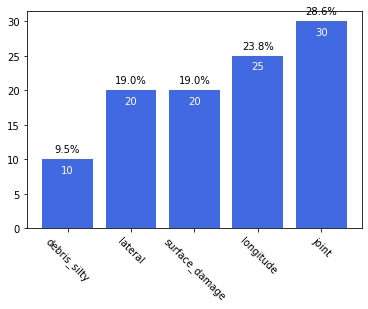

In [8]:
dataframe = pd.DataFrame(list(dict(Counter(trn_loader.dataset.dataset.targets)).values()), index=trn_loader.dataset.dataset.class_to_idx.keys())
dataframe = dataframe.sort_values(by=0)
bars = plt.bar(dataframe.index, dataframe[0].values, color='royalblue')
width = bars[0].get_width()
total = sum(dataframe.values)
index = range(len(dataframe))
for i in index:
    value = dataframe[0][i]
    plt.text(i, value+1, "{:.1f}%".format(float(value/total *100)), ha="center")
    plt.text(i, value-2, value, ha="center", color='white')

plt.xticks(index, dataframe.index, fontsize=10, rotation=-45)
plt.show()

# 학습 진행 내용을 파일로 저장하기 위한 폴더 및 파일명 준비
- 일반적으로 딥러닝 모델은 학습이 오래 걸리기 때문에 학습 중간마다 진행 내용은 반드시 파일로 저장 시켜두는 것이 필요
- "./output/모델명_실행시간/" 폴더에 모델에 대한 정보를 저장함

In [9]:
starttime = str(datetime.datetime.now()).replace(" ","_").replace(":","")[0:-7]
model_name = "{}_{}".format(model.__name__, starttime)
output_dir = os.path.join("./output", model_name)

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

output_filename = os.path.join(output_dir, model_name)
plt_file = "{}.png".format(output_filename)

# GPU 사용 가능 여부 체크

In [11]:
use_cuda = True
print("GPU 사용 가능 여부: ", use_cuda)

GPU 사용 가능 여부:  True


# 학습 시작

In [12]:
# 학습 시작
%time
traind_model, trn_loss_list, trn_aucc_list, val_loss_list, val_aucc_list, confusion_matrix = train(model, num_classes, epochs, trn_loader, val_loader, learning_rate= learning_rate, output_filename = output_filename, use_parallel = use_parallel)
torch.cuda.empty_cache()

Wall time: 0 ns
time: 3.9885 | epoch: 1/10 | trn loss: 1.6199 | trn_aucc: 0.1923 | val loss: 1.7600 | val aucc: 0.3333 | val f1: 0.3027
['debris_silty', 'joint', 'lateral', 'longitude', 'surface_damage']
tensor([[1., 2., 0., 1., 1.],
        [0., 4., 0., 1., 2.],
        [1., 1., 0., 1., 2.],
        [1., 0., 0., 2., 4.],
        [0., 1., 0., 0., 2.]])
time: 0.6034 | epoch: 2/10 | trn loss: 1.5236 | trn_aucc: 0.3846 | val loss: 2.4148 | val aucc: 0.2222 | val f1: 0.1683
['debris_silty', 'joint', 'lateral', 'longitude', 'surface_damage']
tensor([[0., 1., 0., 2., 2.],
        [0., 3., 2., 2., 0.],
        [0., 3., 0., 2., 0.],
        [0., 4., 0., 3., 0.],
        [0., 1., 0., 2., 0.]])
time: 0.5785 | epoch: 3/10 | trn loss: 1.5883 | trn_aucc: 0.4872 | val loss: 2.4028 | val aucc: 0.2593 | val f1: 0.1927
['debris_silty', 'joint', 'lateral', 'longitude', 'surface_damage']
tensor([[0., 5., 0., 0., 0.],
        [0., 3., 1., 2., 1.],
        [0., 3., 0., 2., 0.],
        [0., 3., 0., 4., 0.]

# 모델의 결과 차트로 출력

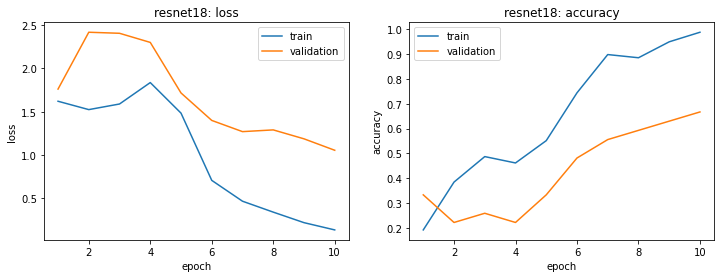

In [13]:
name = model.__name__
x = list(range(1,epochs+1))
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(x,trn_loss_list)
plt.plot(x,val_loss_list)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title(name + ": loss")
plt.legend(['train', 'validation'])

plt.subplot(122)
plt.plot(x,trn_aucc_list)
plt.plot(x, val_aucc_list)
plt.title(name+ ": accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

if plt_file :
    plt.savefig(plt_file)
plt.show()